# W266 Final Project -- Restarurante Dataset

Authors: Satheesh Joseph, Catherine Mou, Yi Zhang

# Part 1: Downloading and preparing the data

We acquired the dataset from the researchers in the form of Sqlite `.db` files.

In [2]:
# Imports
import os, sys, re, json, time, unittest
import itertools, collections
from importlib import reload
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime

import numpy as np
from scipy import stats
import pandas as pd
import sqlite3
import unicodedata
import nltk

import tensorflow as tf
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, InputLayer, Embedding
from tensorflow.keras.layers import TextVectorization
import tensorflow_text as text  # Registers the ops.

from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_hub as hub

import tensorflow.keras as keras
from tensorflow.python.keras import utils

In [2]:
# Download the files if they're not here
if 'data' not in os.listdir('.') or not os.listdir('data'):
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpHotelData.db -P data/')
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpResData.db -P data/')
    print('Data downloaded successfully!')
else:
    print('Already downloaded data')

Already downloaded data


In [3]:
# Load data from the database
con = sqlite3.connect('data/yelpResData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())


[('review',), ('restaurant',), ('reviewer',)]


In [4]:
# Reading from the restaurant database
restaurant_db = sqlite3.connect("data/yelpResData.db")
restaurant_db.text_factory = lambda x: x.decode("utf-8", errors='ignore')
restaurants = pd.read_sql_query("SELECT * FROM restaurant", restaurant_db)
restaurant_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", restaurant_db)
restaurant_reviewers = pd.read_sql_query("SELECT * FROM reviewer", restaurant_db)

print(f'The data set contains {len(restaurant_reviews)} reviews, and {len(restaurant_reviewers)} reviewers')

The data set contains 67019 reviews, and 16941 reviewers


In [5]:
# Data Cleaning
restaurant_reviews['reviewContent'] = restaurant_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
restaurant_reviews['date'] = restaurant_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))


In [18]:
# Split data according to the research paper, i.e. balanced new reviews after 2012-01-01
restaurant_X_test = restaurant_reviews[restaurant_reviews['date'] >= datetime.datetime(2012, 1, 1)]
restaurant_X_test = restaurant_X_test.sort_values('date', ignore_index=True).groupby('reviewerID', as_index=False).first()
restaurant_y_test = restaurant_X_test['flagged'] == 'Y'
restaurant_X_train_and_dev = restaurant_reviews[restaurant_reviews['date'] < datetime.datetime(2012, 1, 1)]
restaurant_X_train, restaurant_X_dev, restaurant_y_train, restaurant_y_dev = train_test_split(restaurant_X_train_and_dev, restaurant_X_train_and_dev['flagged']=='Y')


# Part 3: Model Training

## Preparing for the word embeddings

In [7]:
# GloVe Embeddings
# Download the GloVe embeddings
if 'embedding' not in os.listdir('.') or not os.listdir('embedding'):
    os.system('wget http://nlp.stanford.edu/data/glove.6B.zip -P embedding/')
    os.system('cd embedding && unzip glove.6B.zip')
    print('Data the GloVe embedding successfully!')
else:
    print('Already downloaded the embedding')
    
# Use the 100 dimensional GloVe embedding
path_to_glove_file = "./embedding/glove.6B.100d.txt"

glove_dimension = 100
glove_embedding_map = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embedding_map[word] = coefs

print("Found %s word vectors." % len(glove_embedding_map))

def get_glove_embedding(word):
    return glove_embedding_map.get(word.strip(), None)


Already downloaded the embedding
Found 400000 word vectors.


In [8]:
# Pre-trained Elmo
elmo = hub.load("https://tfhub.dev/google/elmo/3")

def get_elmo_embedding(words):
    return elmo.signatures['default'](tf.constant(words))['elmo']


2021-11-27 17:34:37.553966: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model 1: GloVe Embedding + Plain LSTM

In [13]:
def build_model_1_restaurant(num_epochs=2, sequence_length=50):
    
    # First layer, vectorizing the word input
    m1_restaurant_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m1_restaurant_vectorizer.adapt(restaurant_X_train['reviewContent'].to_numpy())
    m1_restaurant_voc = m1_restaurant_vectorizer.get_vocabulary()

    print(f"Model 1: restaurants reviews vocabulary size is {len(m1_restaurant_voc)}")

    # Build + Lock in the Embedding layer from GloVe
    # Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
    hits = 0
    misses = 0
    num_words = len(m1_restaurant_voc)

    # Prepare embedding matrix
    m1_restaurant_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m1_restaurant_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m1_restaurant_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            print(word)
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m1_restaurant_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m1_restaurant_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    restaurant_X_train_ready = m1_restaurant_vectorizer(restaurant_X_train['reviewContent']).numpy()
    restaurant_X_dev_ready = m1_restaurant_vectorizer(restaurant_X_dev['reviewContent']).numpy()
    restaurant_X_test_ready = m1_restaurant_vectorizer(restaurant_X_test['reviewContent']).numpy()
    print(f'training set shape: {restaurant_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_1_restaurant')
    model.add(m1_restaurant_embedding_layer)
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(restaurant_X_train_ready, restaurant_y_train, epochs=num_epochs)

    # Evaluate on the dev set
    restaurant_y_predicted = model.predict(restaurant_X_dev_ready)
    print(classification_report(restaurant_y_predicted > 0.5, restaurant_y_dev))
    print('Dev set class distribution')
    print(restaurant_X_dev['flagged'].value_counts() / len(restaurant_X_dev))

    # Evaluate on the test set
    restaurant_y_predicted = model.predict(restaurant_X_test_ready)
    print(classification_report(restaurant_y_predicted > 0.5, restaurant_y_test))
    print('Test set class distribution')
    print(restaurant_X_test['flagged'].value_counts() / len(restaurant_X_test))


In [14]:
build_model_1_restaurant(sequence_length=None)

Model 1: restaurants reviews vocabulary size is 81064

[UNK]
dougs
werent
youve
xoco
giordanos
delish
hopleaf
pequods
ginos
guac
hadnt
superdawg
theyve
irazu
gejas
yelpers
shouldnt
brazzaz
theyll
wouldve
spacca
kumas
chicagos
davanti
malnatis
wakamono
bday
opart
chicagostyle
demera
deepdish
theyd
everyones
icosium
saganaki
bonsoiree
itll
sapori
ahogada
couldve
mastros
chitown
housemade
anteprima
sabatinos
zed451
bistec
pasadita
yelper
5star
caldos
wifes
artopolis
fifty50
dinein
breakfastbrunch
outoftown
drivein
shouldve
potstickers
calos
highend
gunthorp
décor
outoftowners
httpwwwyelpcombiz
croquetas
smores
resturant
baconwrapped
planxa
entrée
cmon
banchan
tshirt
café
messob
flautas
bonein
thincrust
mmmmmm
ceviches
plaintains
shortrib
bussers
glutenfree
patatas
favs
oldschool
ahodaga
shortribs
meltinyourmouth
proscuitto
panang
funghi
delicous
cochinita
soooooo
omlette
xao
sandwhich
gnocci
mousaka
dominicks
arrachera
salsiccia
ohare
crabcake
choriqueso
3045
maduros
francescas
busser


nofrills
napolis
michetabish
mercats
menubut
masaman
masago
marshmellow
lulas
looove
lolla
lawrys
lactoseintolerant
knackwurst
kasseri
ityou
italianstyle
impecable
housebrewed
homefries
hickorysmoked
herebut
hardearned
halfempty
griglia
goooooood
gnudi
gnochi
getgo
georgettis
gaminess
fruitti
frituras
freshbaked
franciscos
foody
foodso
foodnot
foodit
foodgasms
flavorable
flanes
firsttime
familyfriends
fallwinter
excellant
ensalada
enoughi
earlyish
draculas
doover
dissapointment
disapointing
dinneri
dietzler
defnitely
davantis
crêpes
creamiest
corndogs
coobah
conchiglie
coffe
chimichuri
chilequiles
chickn
chicagothe
chicagobased
chicagoand
cheesei
cheescake
cemitas
bytheglass
butifarra
bulkoki
btch
bomieh
bluecheese
bharta
bernaise
barlike
avocadotomatillo
atomsphere
argula
allamerican
alacarte
aholes
aboveaverage
9ish
915pm
845pm
815pm
700pm
57pm
4850
3oz
3chile
2top
10ish
zatar
yummmmmmm
yummier
yesi
yeshimbra
yebeg
yanyao
wsome
wowi
wowd
whatev
wellspiced
wellinformed
wchicken
wchee

visitng
visitand
vinager
viettown
vietstyle
veija
vegvegan
vegis
veghead
vegetarianmeat
vegetariana
veganaise
valhrona
über
ushe
ushaped
usand
unrushed
unodue
unfortunatley
uneatable
underimpressed
underflavored
undercharged
uncomfy
ukie
twoway
twosided
twoseater
twiceonce
twicebaked
tvh
tunapork
tumeric
tubeshaped
tsingtaos
trythe
tryed
trully
truley
trufflechestnut
truethe
trappistes
traditionalstyle
tortelloni
torreja
toptier
topoblamo
topheavy
topbut
tootight
tooit
tooa
toeat
toasti
tlcs
tirimisu
tiradito
timewe
timesthis
timemy
tillapia
threestory
threehour
thoughful
thisi
thinkinghow
thinish
thingys
thingthis
thingi
thereyou
therewe
therethis
thereif
therebut
therealso
thenthe
thatjust
thatit
thatgood
texturewise
testtube
teryaki
telephono
tbones
tastywe
tastetest
tast
taramasalata
tapenades
tablewe
tableit
tablebut
tableand
tableafter
sweetpotato
sux
suuuper
sushii
sushifruit
surpringly
surethe
surebut
superwhite
superchic
supercheesy
superattentive
sunwed
sunthur
suchandsuch
s

vessle
verrry
verrrrrry
verrrrrrrry
verison
vension
venisonyou
vegnews
vegn
veggiesherbs
veggiecurious
vegeterians
vegetablesi
varities
vanillasour
valuepriced
valueoverall
valeted
vajayjay
utterley
usnice
usjust
usbut
usafter
uptowns
upthis
upthey
upnot
uped
upcharges
untilthe
unsweet
unstuffy
unseemingly
unosdues
unmelted
unmarinated
unironed
uniquebut
uniquea
uniqe
unibrou
unhealthier
ungreasy
unfresh
unfort
unexpectantly
underwhelms
underwhelm
undertand
underspiced
underfried
undelightful
uncurded
uncozy
uncomparable
unchewable
unbelivable
unbelievablely
unaccomodating
ummmmmm
ultratouristy
ultrafresh
ultrachic
uichalsted
uhg
ughhhh
ughh
ufb
uberlong
uberhip
uberfriendly
uberfoodies
uberexpensive
ubercool
tzitziki
tzatzki
tyranena
twoweek
twothirds
twothe
twostar
twoor
twolevel
twoi
twoforone
twoday
twinky
twille
twicefried
twentytwo
tvhs
turnofthecentury
turkeycranberrybrie
tummys
tuica
tuffo
tuethurs
tuesdaywednesday
tueben
tuchas
tuben
tubaina
tuans
tthis
tsaziki
tsatsiki
tryyou

magnificentthe
magarita
madewithlove
madeup
madebut
machitos
maaaybe
lyk
luxardo
luved
lushes
lunchsnack
lunchjust
lunchgoers
lunchbuddy
lukaz
ltalian
lplakeview
lowlit
lowlighting
lowincome
lowcarb
lovethe
loveit
loveeeeee
loveeee
loungeoutdoor
loukamades
loudwe
loudso
loudand
lotbut
loster
lordie
looooved
looooove
loooooooove
lookfeel
lookedsmelled
lonnnnng
longwait
longribs
longi
longgo
longbut
lombardis
lolllipops
lollapallooza
locationright
locationi
locationand
locallyraised
localish
lobsterstuffed
lobsterfilled
lizze
liveand
litup
litttle
listyou
listi
listand
listall
liquour
liquers
linquine
linewait
linethe
lineor
linemy
lineit
lindysez
likeyou
likethe
likemaybe
likeits
likedbut
likeand
likean
liitle
lightsout
lightfluffy
lifethe
lifeand
liek
lidiot
licuado
letizias
lessthan
lemoninfused
lemondrop
lemmony
leinenkugels
leftthey
lefrieda
leeche
leavei
leaveand
leastthe
lbomb
laymans
laxed
lavenderlemon
lateryou
laterso
laterns
latemorning
latei
latehe
lateand
lastnight
lasagnave

crawfishcakes
crappiest
crains
cracktacular
crabscallop
crableg
crabcrusted
craaaaazy
coursefoie
coursebut
coursebecause
courseand
countrystyle
cottachocolate
cotechino
costperunitofenjoyment
costeffective
costconscious
costan
cornoat
cornnut
cornmealy
cornichones
cornbreads
coolthey
coolit
coolim
cooli
coolea
cookiesthey
convienent
conversationbut
convenientlylocated
consumme
consomm
connossieur
connosieur
connoseur
connoseiur
connoiseur
conmemorativo
comtemporary
comtemplating
compt
completey
comfycozy
comforatble
comfit
comei
comatosed
colorsi
collegeand
collegeaged
coldwe
coldi
coktail
cokepepsi
coffeetea
coffeeor
coffeegood
coconutpineapplerum
cocoas
cocktailsi
cocktailsand
cocktailing
cochonita
cochettes
coastyou
clubtype
clubsbars
clubesque
clubbin
closetsized
clogger
clientèle
clienteleand
cliantro
clementini
clearwe
clausterphobic
clarkdivision
civiche
citystyle
cityit
cityat
cityand
cioppinobouillabaisse
cinnamonny
cinnamin
cilantroy
cilantroonion
cielings
cieling
churrascur

wowimpressive
wowiewowwowwow
wowguys
woweeee
wowedthe
wowdid
wowbeer
wowamazing
woutso
wount
wouldwill
wouldthis
wouldst
wouldshould
wouldntve
wouldntcouldnt
wouldja
wouldhighly
wouldd
wouldbut
wouilld
wots
wother
wotagain
worthwe
worththewait
worththe
worthly
worthlessly
worthi
worthed
wortha
worstmediocre
worselet
worsei
worsebut
wors
worryill
worryi
worriedwas
wormthe
world­
worldwidewent
worldtraveler
worldtraveled
worldthese
worldthen
worldtender
worldsuch
worldssalty
worldso
worldroad
worldperiod
worldooops
worldlove
worldlets
worldhands
worldfillet
worldand
worlda
workyshmirky
workwhateveri
workwell
workto
workthere
workstudying
workstudy
worksspacca
worksgood
worksflank
worksbut
workoverallambiance
workoholic
workoh
workmy
worklike
workingyou
workingthe
workingmas
workingbut
workhome
workfood
workersowner
workedyou
workedtomatoes
workbirthday
workaurant
worg
wordyummy
wordyuck
wordwow
wordswhite
wordstourist
wordstonys
wordsto
wordsthe
wordsthanks
wordssangria
wordsphrases
word

wackys
wabis
waaayyy
waaaytoolong
waaaiittt
waaah
waaack
waaaayyyy
waaaayyy
waaaahooooo
waaaaayyy
waaaaaaay
waaaaaaaaaayyyyy
waaaaaaaaaaaayyyyyy
w20
w00tah
vvvvvvery
vvvverrry
vultureeyeing
vtown
vry
vowsnothing
vouqueray
vouche
votefor
vosgues
voratious
vongolewhite
vonderlicious
vommity
vomity
vomitous
vomitfood
vomd
voluptuouspizza
volunteerstheater
volunteerassume
volumn
volumei
volumebased
volcanoi
volcanofudge
vokda
voilet
voilawall
voilation
voiceordering
vodkatitoswhat
vodkatini
vodkasodas
vodkasoda
vodkasoaked
vodkaoj
vodkainfused
vodkagrapefruit
vodkacream
vodatinis
vneck
vlasicstyle
vittons
visualtexture
visualaural
visitwhich
visitthis
visitthe
visitswill
visitsso
visitsooo
visitsmore
visitsis
visitour
visitorstourists
visitorsand
visitmy
visitited
visitingand
visitincredibly
visiti
visitfriendly
visitedi
visitedand
visitbefore
visit5
visibile
virtulally
virginsuperdawger
virginitythere
virginiathis
virginiaiowa
virginand
virbant
vipi
vipesque
viped
violetish
violetinfused


tortlaci
tortillini
tortillerias
tortilleria
tortillatyped
tortillathings
tortillasyum
tortillaswow
tortillaswhich
tortillasmmmmmm
tortillasetc
tortillasawesome
tortillaria
tortillai
tortilladelicious
tortillabased
tortellinni
tortasthe
tortass
tortason
tortasi
tortascrusty
tortaria
tortaid
tortacoriqueso
tortaby
tortaat
tortaand
torrito
torota
tores
toreore
tordelle
torchseared
torchbruleed
toquench
topyummy
topyou
topwho
topwater
topthree
topthe
topsoughtafter
topsomething
topsome
topsoaked
topso
topsecret
toprated
toppped
toppolo
toppingsy
toppingsthe
toppingssome
toppingsreally
toppingspequods
toppingsmushrooms
toppingsmeat
toppingsman
toppingsits
toppingsit
toppingshearty
toppingscheese
toppingcheese
toppingand
toppermost
topothemornin
topolovino
topolothe
topolos
topolombombo
topololobampo
topolobompos
topolobompofrontera
topolobomo
topolobomboeven
topolobampofrontera
topolobampa
topoless
topolabompo
topoftheline
topoffs
topobolongo
topobampo
topnotchquick
topnotchif
topnot
topju

tablewhich
tablewell
tablewas
tablevery
tabletheyre
tablethey
tablethere
tablethe
tablethats
tablethat
tabletake
tablesya
tableswithin
tableswhat
tablestry
tablesthey
tablesthats
tablesspaces
tablesso
tablessmushedtogether
tablesshould
tablesseating
tablesrich
tablesparties
tablespace
tablesome
tablesmoked
tablesmaking
tableslamps
tablesjust
tablesi
tablesfortwo
tablesenjoy
tableseating
tableseat
tableschairseekbut
tableschairsand
tablesboothsdining
tablesboothsbar
tablesanyway
tablesa
tablereservations
tableremember
tableor
tableok
tablenumbering
tablenow
tablenor
tableneedless
tablemy
tablemaybe
tablejoint
tableinnovation
tableinduced
tableif
tablegreat
tablefree
tableforget
tablefor
tablefinally
tablefinal
tableduh
tabledeli
tabledance
tablecoth
tablechecked
tablechairs
tablechair
tablecandle
tableby
tablebtw
tablebrewed
tablebooths
tablebooth
tablebonus
tablebest
tablea
tabfinish
tabernero
tabel
tabbut
tabbachi
t29
szetsiki
szechuanthere
szechuanspicy
szechuans
szechauan
systemon
s

soupa
soundtracklots
sounddeafening
soundabsorptive
soultheir
soulshattering
soulscorchingly
soulsatisfying
soulfood
soufflé
soufflelike
sotwo
sottobosco
sotospeak
sothings
sotheres
sothe
sothats
sosowords
sososososos
sosososo
sososogood
sososo
sosos
sosorry
sosoif
sosoid
sosogood
sosoatbest
soseeing
sortsit
sortseriuosly
sortoh
sortagf
sorrywhoops
sorrythat
sorryrepresenting
sorrying
sorryif
sorryi
sorryfries
sorrycouldnt
sorrybut
sorryass
sorryapparently
sorries
sorghumglazed
sorbetgelato
sorbetakin
sorbertsicre
sopretty
sopranosy
sopranosesque
soppressetta
soppresetta
sopporo
soppin
sopp
sophistocated
sophisticatedwe
sophisticant
sophisicated
sophias
sooverallwould
sooverallit
sooverall
soothingit
soosh
sooothing
sooosh
soooothe
soooooowe
soooooooverall
sooooooooooooooooooo
sooooooon
soooooeeey
soooooanywaysi
soooner
soooi
soonyou
soonwill
soonwell
soonwe
soontoexpire
soontobemom
soontobemarried
soontobeemployer
soontobecustomers
soonthere
soonthe
soonstaff
soonjust
soonit
soonhowe

sculpturelike
scruptious
scrupmtious
scrunchie
scrumtrulescent
scrumtastic
scrumpty
scrumptiouslooking
scrumptiousim
scrumptiouseverything
scrumpteous
scrumpdilliuptious
scrumpdiddlyumtious
scrumpdiddlyumptious
scrummy
scrumdillyumptious
scrumdiliumchious
scrumdidilyumptious
scrumcious
scruffgruff
scrubclad
scrounges
scrore
scriptthe
scrimpy
scrimps
scrilla
screwwhat
screwer
screwem
screenswhich
screensare
screenprinted
scredded
screan
screamingmorei
screamingatthe
screamingacrossthetable
screaching
screached
scratchfree
scratchand
scrapmetal
scrapeyourplate
scramps
scrampled
scrammbler
scramlers
scrambleeggs
scrambledegg
scoutmob
scous
scounch
scottsman
scotchwhiskeybourbon
scotchs
scosh
scorseseesque
scorebourbon
scordalia
scooptype
scooched
sconnie
sconelike
sconch
scolar
scimp
scientistgeneral
scientistbrains
sciencemeetscooking
schwermas
schwasted
schwarmma
schwarama
schwaps
schwapeople
schwaoh
schwame
schwaand
schvitz
schucking
schuan
schpiels
schoolstyle
schoolcollege
schoolclas

rigattoni
rigatoniloved
riganti
rigamati
rieslingterrible
riempire
riduculously
riduclousfor
riduclous
ridoncolous
ridiulously
ridiulous
ridicuously
ridiculousy
ridiculousstop
ridiculouspulled
ridiculousother
ridiculousnesss
ridiculousgood
ridiculousbut
ridiculous18
ridiculist
ridicously
ridewhat
rideless
rideits
ridculously
ridculous
ricottastuffed
ricottalemon
ricottahoneycheese
ricottafilled
ricottaexcellent
ricottablueberry
ricottablah
ricothis
rickkk
rickity
rickit
richwild
richwalnut
richthe
richs
richnot
richnessoh
richmelt
richlyscented
richlike
richin
richies
richheaven
richbuttery
richbut
riceyumm
riceyum
riceyou
ricewhat
ricewater
ricewall
riceto
ricesheer
ricesalad
ricerocket
riceoooh
riceoh
ricenot
ricemmmmm
ricemiso
ricemeat
riceloving
riceloved
ricelentil
ricelasts
riceits
riceit
riceis
riceduck
ricedelicious
ricechicken
ricecant
ricecake
ricebox
riceboth
ricebeefshrimpegg
ricebean
ricebad
ricebacon
riceandlentils
riceall
riceabsolutely
ricctta
riccota
riccan
ricatta
ric

possibilties
possbly
posioning
posion
poshy
poshthats
poshified
portyou
portugal10
portobellas
portlands
portitions
portionwise
portionwe
portiontoprice
portionthe
portionsyou
portionsvalue
portionsthey
portionsthe
portionsonly
portionslots
portionsitems
portionshinthint
portionshighly
portionseven
portionsbut
portionsat
portionprice
portionits
portioncould
portionbut
portionbig
portio
porticcino
portfoilio
porterhouseall
porteralso
portcompressed
portcherry
portbella
portabellascallop
portabellas
porrige
porridgelike
porny
porkyum
porkys
porkyep
porkwe
porkvery
porkthey
porktastic
porksuper
porksteak
porkso
porkshrimp
porkshocking
porksee
porkrinds
porkrindish
porkpork
porkpolenta
porkplantain
porkoystersbeer
porkoysterbeer
porkoriented
porkopolis
porkon
porkmy
porkmmm
porklovers
porklike
porklican
porklard
porkkimchi
porkit
porkish
porkiness
porkier
porkholy
porkgarlic
porkfruit
porkfree
porkfor
porkfest
porkexcellentcomrade
porketta
porkeaters
porkdominated
porkcoleslaw
porkchopsric

paneracorner
panelas
paneerthe
paneers
paneerlike
paneed
panecatta
pancrust
pancitthey
pancita
panchossee
panchanwhatever
panchanappetizers
pancettta
pancakey
pancakewow
pancakewafflefrench
pancakewaffle
pancakesyum
pancakeswhite
pancakeswe
pancakesunfortunately
pancakesumm
pancakestoo
pancakesthis
pancakesnot
pancakesmy
pancakesmade
pancakeslemon
pancakesfrench
pancakesfall
pancakeseverything
pancakeseehhh
pancakesas
pancakesamazing
pancakeomeletpanletteomcake
pancakefrench
pancakeflapjack
pancackes
panacottathe
panacotta
panackes
pamelas
palmina
palletwhen
palletjust
pallete
palletable
pallazo
pallatos
pallate
palid
palettecleansing
palettecleanser
palett
palet
paleofriendly
palces
palatestimulating
palatesmind
palatei
palatechanging
palatechallenged
palateable
palatas
palatably
palapitaim
palapas
palamino
palacsinta
palaceyou
palacethe
palacenot
palaceits
palaceit
palaceey
palaak
pakorey
pajzos
pajengo
paisaribeye
paironion
pairingweird
pairingthe
pairingtasting
pairingsyes
pairings

notits
notit
notingi
noticies
noticewithout
noticewait
noticeespecially
noticedtheir
noticecare
nothot
nothng
nothis
nothingvery
nothingthe
nothingnot
nothingmaybe
nothingliterally
nothingits
nothingi
nothinghappening
nothingawesome
nothingall
nothingabsolutely
nothing3its
nothernly
nothere
nothat
notgreat
notforprofit
notfor
notfeel
noteworthyand
notesor
notequippedwithbrakes
notemy
notecheck
notebyob
notdisappoint
notdiner
notcrowded
notchthe
notchlongman
notchand
notbut
notburntbutalsoalittleburnt
notbad
notax
notatallchewy
notasecret
notariety
notanyway
notand
notalking
notaio
not2
nostros
nostrilthere
nostelgia
nosotapas
nosince
nosiey
noshin
nosheries
noseypros1the
nosesame
noseif
nosei
norush
northy
northwith
northwesternindianaillinibearsmichigan
northsouth
northmilwaukeedamen
northloved
northlincoln
northiside
northgold
northface
northend
northdowntown
northdamenmilwaukee
northcenterlincoln
norteas
normalthin
normalpaced
normalnice
normallynotabigfanofencasedmeats
normallyctab

mediorce
mediocure
mediocur
mediocrityin
mediocreto
mediocrethe
mediocreplate
mediocrelots
mediocredawg
mediocrebut
mediocrebland
mediocreand
mediochre
medimum
medievallooking
medicinallooking
mediaum
medialions
medevil
medeira
medefinitely
mecomes
mechanicalservers
meccathere
meccamy
mecarlson
meby
meaverage
meatyhe
meatwizards
meatwise
meatwild
meatwhich
meatwhere
meatwellwhat
meatversion
meatveggieoil
meatvegetarian
meatvegetables
meatvegetable
meaturday
meattreat
meattoveggie
meattoss
meatto
meatthis
meatthese
meattheres
meattherefore
meatthat
meattender
meatsyummmmm
meatsweats
meatstyle
meatstuffedmeat
meatstrout
meatstheyre
meatsteak
meatssmall
meatsseafoods
meatssausageswhatever
meatssausages
meatspoultry
meatsooooooooooo
meatsjuicy
meatsits
meatsingredients
meatside
meatshrimplobster
meatseven
meatserving
meatserved
meatseriouslybut
meatseafoodveggies
meatsdelicious
meatsave
meatsausage
meatsand
meatrelated
meatregular
meatreal
meatranger
meatpoultryseafood
meatpotatoescornicho

lolz
lolwell
lolwe
lolwas
loltrust
loltheir
lolthe
lolsteaks
lollygagged
lollipopsyum
lollipopswell
lollipopsi
lollipopsflavor
lollipopsdoes
lollapolooza
lollalike
lolipops
loling
lolhe
loled
lolbany
lolanyhowdidnt
loland
lokumades
lokomades
loiss
loinclothedhotdog
loinclothed
loillpops
lohans
logomascotwhatever
logoa
loganwickerbucktown
loganhumboldt
loftycontemporarycool
loftstyle
locopanko
lockbroken
locationwhatever
locationtrying
locationthose
locationthis
locationthe
locationtaking
locationparty
locationone
locationno
locationmy
locationjust
locationdid
locationcons
locationbut
locationally
locationall
locatedbut
localthis
localthey
localswe
localsustainable
localseasonal
localregional
localorganic
locallymade
locallygrown
localites
localhipsterpizza
localgreen
localcheck
lobsterwhich
lobsterwagyu
lobstertail
lobstersomethingorother
lobstershrimpanythingwashell
lobstersea
lobsterscented
lobsterroe
lobsterricotta
lobsterpopcorn
lobsterfilet
lobsterfestmy
lobsterfennelbroth
lobster

itnice
itmortal
itmmmmmpatio
itmmm
itmint
itmelt
itmeh
itmakes
itmake
itmachitohuge
itloved
itlol
itlearned
itladies
itjust
itincluding
itimate
ithot
ithink
ithence
ithamachi
ithallelujahand
itha
itgrilled
itgood
itgiordanos
itfrom
itfreakin
itflaunt
itfirst
itfine
itfast
iteww
iteven
iterationsalcohol
itemthey
itemthe
itemswhich
itemsthat
itemsand
itemplan
itemperfectly
itemclass
itembut
itemand
itelien
itdown
itdoug
itdont
itdoesnt
itdessert
itdescriptions
itdelish
itdelicious
itdefinitely
itdecided
itdammmmn
itcuz
itcould
itcoffee
itclearly
itchanged
itcame
itbrad
itboth
itbooked
itbeing
itbecuse
itbasically
itat
itas
itapples
itanyhoo
itammmmazing
italysuper
italynow
italyjust
italyhaha
italyesque
italycome
italy4
italso
itallian
italianwhich
italianspanish
italiansocca
italianseasoned
italianpizza
italianostyle
italiannot
italiannapa
italianmediterranean
italianit
italianish
italianinspired
italiangreekspanish
italiangreek
italianesque
italiandim
italiancheese
italiancentric
itali

highrankings
highprofile
highprices
highlytraveled
highlysubjective
highlyskilled
highlyrated
highlypraised
highlyopinionated
highlyjan
highlyacclaimed
highlite
highlightthe
highlightsthe
highlightsknowledgeable
highlightand
highlighs
highlarious
highheels
highheeled
highheat
highgrease
highfruittoast
highfivin
highfives
highfive
highestthe
highestrated
highestend
higherups
higherthaniwanttopay
higherprofile
highermargin
higherclass
highendish
highdont
highculture
highcontrast
highconcepty
highcheese
highchairsturnedupsidedown
highceiling
highcalorie
highcalibre
highbut
highbrowed
highalcohol
high50s
high16
hifived
hibscus
hiboy
hibiscusinfused
hibicus
hiberate
hibachis
hhhhooourrrssssmy
hfcsfree
hezzzzy
heywho
heywell
heywe
heythey
heythe
heyo
heyjust
heyit
heydouchebags
heydid
heydayand
hewls
hewe
hevenall
hethey
hesitatively
hesitationto
hesitatingly
hesitatebest
hesitantlyplease
herwed
herwe
herthis
hershes
hershe
herselfturns
herselfshes
hersand
heroworship
hericot
hereyum
hereyou

gnoccidelightful
gnocchithe
gnocchitasty
gnnochis
gnawfriendly
gmhe
gmbad
gmas
gmart
glyko
gluttonoussniffle
gluttoning
gluttonfest
gluttonbut
glutten
gluteny
glutensensitive
glutenpolicing
glutennaysayers
glutenfilled
glutened
glutendairy
glutenceliac
glutany
gluelike
glucoseand
gltb
glss
gloveleather
glossyeyed
gloriousness
glorifed
glopp
globby
gloatjerks
glittzier
gliteratti
glimse
gliblythis
glennsits
glennsit
gleen
glauc
glassthey
glassplated
glassnow
glassmakes
glasslooking
glasslooked
glasslogo
glassgo
glassfront
glasseswtf
glasseswe
glassesthere
glassesthe
glassesotherwise
glassesonly
glassesone
glassesim
glassesget
glassesdont
glassesclad
glassesalready
glassedin
glassdecor
glassculminating
glassandmetal
glassand
glassall
glaised
gladd
glacegel
giveup
givesyou
givesi
giveld
givejust
giveem
giveand
gitup
gitdafuckouttahere
girlyman
girlwhite
girltown
girlthree
girltalkjust
girlsthen
girlson
girlsnightoutters
girlsnightout
girlsnight
girlsand
girlriesling
girlllll
girlfriendy
g

fixie
fixedmenu
fiveway
fivescoop
fivers
fivepepper
fivehour
fiveeverything
fiveegg
fivedom
fivedollamakeyouholla
fitta
fitmaybe
fisty
fistpump
fishyou
fishygreasy
fishyespecially
fishyadda
fishwhich
fishveggie
fishthis
fishthey
fishstew
fishrice
fishrabbit
fishpastichiooh
fishoutofwater
fishnonsteak
fishmy
fishmia
fishmeateaters
fishmeat
fishive
fishit
fishiest
fishhouse
fisheating
fishdinner
fishdealers
fishcoast
fishchip
fishchicken
fishcakes
fishawfullike
fishand
firstwhoever
firstvery
firstservice
firstscallops
firstname
firstmmmmm
firstmake
firstknow
firstjobbed
firstif
firstfloor
firstfavorite
firstday
firstcocktails
firstas
firstand
firmread
firkinbeer
firies
fireyou
firewhen
firesone
firequaker
firepot
fireplacewe
fireplacestove
fireplaceseveral
firepits
firepit
firenzian
firendsfamily
firend
firegrilled
firedog
fireddont
firedarriving
firecaracker
fiorentine
fionas
finto
finski
finishso
finishout
finishmy
finishif
finishedvery
finishedseveral
finishand
finglerling
fingersok
f

ehmquite
ehive
ehit
ehishly
ehhthe
ehhnot
ehhi
ehhhoknot
ehhhive
ehhhhhnot
ehhhhhhhhh
ehhhand
eheh
ehdont
egullet
egshell
egregiousand
egotisitical
eghh
eggz
eggtruffle
eggtoast
eggsyes
eggswell
eggstuffed
eggstrordinary
eggstraordinary
eggsteak
eggstatically
eggstatic
eggspress
eggspotatoestoast
eggsploded
eggsplaintainsget
eggsperinece
eggsperience
eggspectation
eggsomelets
eggsmilk
eggsit
eggsif
eggshe
eggseeded
eggsdairy
eggschorizopotato
eggscellent
eggsbéarnaise
eggsbenedictloving
eggsbacons
eggsallent
eggsall
eggrolltype
eggregious
eggquail
eggpork
eggplantwhy
eggplantit
eggplantand
eggontop
eggmushroom
eggly
egglayonaise
egglants
egglant
egginess
eggies
eggi
egghash
egggg
eggfantasticand
eggeat
eggdelish
eggcited
eggcheddartomato
eggceptionally
eggceptional
eggcelent
eggbut
eggbreakfast
eggbiscuit
eggbaconhome
eggbacon
eggawesome
eggandbread
eggall
efrons
effluvium
effiicent
efficiencythe
effed
effecient
effd
eeyores
eessshhh
eesh
eeri
eensy
eementhal
eelanyway
eeks
eeked
eega

delibakerybarrestaurant
deliah
delevered
deletable
deleecesee
deleece
delectableoh
delectableness
delectability
deleciously
delecious
delecacies
delcisiouso
delcicious
dekoninck
dekonick
dejour
dejoung
dejogne
dejoghne
dejaughn
deilsh
deilcious
deifnitely
deicated
deian
dehyrated
degustations
degreestherefore
degreesand
degredation
degrease
defrtosted
defriending
defreakinlicious
deflatedit
defitnely
definttely
definitiely
definitey
definitelycrowded
definintely
defininatly
definiely
definently
definentely
definateley
definate
definanely
defiinitely
defiantely
deffinatly
deeta
deescelate
deerishous
deepvein
deeppurplecolored
deeplyingrained
deepliscious
deepfrying
deepfryer
deepfry
deepfries
deepfriend
deepestbaby
deepdishpizza
deepdishpequods
deepdishpan
deepdishonly
deepdishesnot
deepdishes
deepdishdom
deepbrown
deepakthis
deenied
deelious
deelectable
deeelush
deeeerunk
deeeefinately
deeeeep
deeeeeelishness
deeeeeeevine
deeeeeeelicious
deeec
deec
decriptions
decribe
decr
decoturn
dec

concurbest
concotion
concoctionduck
concoctionbut
concocation
conclusionisnt
conclusioni
concisewe
concious
concion
concieve
conciergeroom
concientious
concidering
conchinita
conchigli
conchigle
conchanita
concertlive
concertart
concersations
conceptwhich
conceptthoughtful
conceptssee
concepting
conceptif
conceptcreativity
conceptcooking
comunicate
comté
comsumptionthis
comraderie
comradeit
comprable
componentsthe
componenti
componants
componant
compliomentary
complimment
complimentsofthekitchen
complimentry
complimentarywhen
complientary
complicatedhow
compliation
compliants
complexyes
complexitysimplicity
complexityrarity
complexat
completlysince
completly
completethis
completesomething
completeis
complaintyou
complaintthey
complaintthe
complaintswe
complaintsits
complaintsfood
complaintsbitterfogolover
complaintsat
complaintsand
complaintnearly
complaintmistake
complaintgo
complaintbeing
complaint450
complaint225
complainit
complainingi
complainin
complainbut
complaiing
compileyour

cautionbe
caulifower
cauliflowerthe
cauliflowerpear
cauiliflower
caturpiry
catruth
cathys
catholicself
catfishyum
catery
caterpiller
cateringim
catereres
catdaddy
catchs
catchet
catapillar
catalunyayou
catalunia
catalonianspanish
catalonianinspired
cataloniabased
catalanian
catalanbarcelonarelated
catalanaokay
casuelas
casualthere
casualthe
casualstyle
casualromantic
casuallove
casuallaid
casualish
casualfine
casualelegant
casualdressy
casualcozy
casualcool
castleyes
castiron
castelinhos
castanyes
cassolette
casserolestyle
casserolelike
casserol
cassadys
caskconditioned
casingwith
casingreally
cashyou
cashsmall
cashs
cashonlyopentill4
cashonlymy
cashno
cashits
cashierserver
cashiermanager
cashierhostess
cashierhelper
cashgo
cashfree
cashewpotato
cashdollars
cashbut
caseys
casewhere
casette
casesar
caserole
caserita
caseit
casedont
casedmeat
casear
cascabeltomatillo
casaluella
casalinga
casadoyummy
casadojuicy
casadoa
carvivale
carverowners
caruchon
cartwhere
cartoonand
cartnita
cartman

bottomofthebarrel
bottommight
bottomlinegreat
bottomlesswhich
bottleyes
bottleswe
bottlesthey
bottleoverall
bottleor
bottleit
bottleim
bottlegulp
bottlecans
bottleblonde
botticelliesque
botthle
botthe
botoxed
botle
bothwereamazing
boththat
bothi
bothespecially
botheryuck
bothbesides
bothattentive
bothand
boteró
boteros
botchulism
botarga
botana
bostonthe
bostonnew
bostonianmy
bosstakingyououtforyourbday
bossive
bossish
bossbossto
bossand
boss4
bosies
borring
borregotexture
borrata
borrachos
borrachas
borolo
borni
boriquas
boringwe
boringtown
boringthe
boringmaybe
boringgoat
boredannoyed
borderlinerude
borderlinelived
bordeoux
bordelet
borani
boquerones
bopi
boozytasting
boozle
boozewise
boozeskill
boozes
boozefree
boozefilled
boozefall
booya
boothyou
booththings
boothsyeahalice
boothswalls
boothsthe
boothsnice
boothsi
boothsanywhere
boothsand
boothlike
boothi
boothcubbyholes
boothcouch
boothboxes
boothbar
booooyyy
booooring
boooooy
boooooooooo
boooooooom
boooooo
booooomb
booooom
boooo

avewhat
avewe
averagetastingburger
averagesize
averageoverall
averageor
averagenext
averagemaybe
averageit
averageish
averagebut
averagebelow
average11
aveoutside
avenuethe
avenuegrade
avemilwaukeedamen
avemillenium
aveglamonado
avecthe
avecblackbird
avecare
aveage
avatard
avanthaute
avalibe
avaliable
availalble
availablity
availablewe
availablethe
availablethats
availablesuccess
availablenothing
availableeven
availabledisappointing
availablebut
availableantelope
availableand
availabilty
availabilityseasonality
avaiable
avagalemeno
avacadoyumyum
avacadotaro
avacadonasse
avacadonaise
avacadoits
avacadogouda
auuuughhh
automats
autolock
autograted
autograt
autofrench
authenticso
authenticright
authentico
authenticneapolitan
authenticlots
authentickind
authenticiy
authenticityvalue
authenticitalian
authenticfreshimported
authenticflavorfulfilling
authenitc
authenic
autentico
autentic
austrailian
austinetcmy
austindallas
auntinlaw
augolemono
augh
audiencethe
audienceif
audibled
aucune
atzec

againlove
againleft
againits
againhowever
againhot
againhopefully
againgross
againgrilled
againget
againfood
againfo
againexpect
againdidnt
againcrispy
againat
againany
again3
afuckingmazing
aftr
afterwordsavoid
afterwe
afterwardthe
afterwardsits
afterwardnot
afterthoughtbasically
afterthefact
afterthe
aftertastelikethe
aftershow
aftershopping
afterservice
afteroops
afternoontry
afternoonthey
afternoonso
afternoonsafter
afternoonit
afternooni
afternoonfantastic
afternoondefinitely
afternoonbest
afternoonand
afternoon10
aftermeal
afterhour
aftergame
aftercivilunion
afterbusiness
afterbc
afteralongnight
after1230
aftenoon
afriggindorable
africkin
afreakingmazing
afreakingdorable
afortable
afligem
aficionadomy
aficianados
affordabley
affordableor
afforadable
afforable
affodrable
afficianados
affagato
aestheticallypleasing
aerosmiths
aeronsunda
advocanaisse
advisedont
advicenavigation
adviceif
advicefind
adviced
adviceask
adviceas
advertizement
adverterous
adventurousso
adventurousfoodincl

training set shape: (42086, 976)
Model: "model_1_restaurant"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         8106400   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,148,705
Trainable params: 42,305
Non-trainable params: 8,106,400
_________________________________________________________________
None
Epoch 1/2
  26/1316 [..............................] - ETA: 15:16 - loss: 0.5631 - accuracy: 0.8786

KeyboardInterrupt: 

In [26]:
for num_epochs in [5, 10, 15]:
    for sequence_length in [100, 200, 400]:
        print(f"Start training with num_epochs={num_epochs}, sequence_length={sequence_length}")
        build_model_1_restaurant(num_epochs=num_epochs, sequence_length=sequence_length)

Start training with num_epochs=5, sequence_length=100
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 100)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         5801400   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,894,905
Trainable params: 93,505
Non-trainable params: 5,801,400
_________________________________________________________________
None
Epoch 1/5
107/107 [==============================] - 11s 84ms/step - loss: 0.3922 - accuracy: 0.8721
Epoch 2/5
107/107 [======

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=200
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 200)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 400)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_2 (LSTM)               (None, 64)                93440     
                                                                 
 dense_

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=100
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 100)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_3 (LSTM)               (None, 64)                93440     
                                                                 
 dense

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=100
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3402, 100)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_6 (LSTM)               (None, 64)                93440     
                                                                 
 dense

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

## Model 2 - Data Resampling + GloVe Embedding + LSTM

In [15]:
# Split the positive/negative samples for more balanced sampling
restaurant_X_train_positive = restaurant_X_train[restaurant_X_train['flagged'] == 'Y']
restaurant_X_train_negative = restaurant_X_train[restaurant_X_train['flagged'] == 'N']

print(f'There are {len(restaurant_X_train_positive)} positive examples')
print(f'There are {len(restaurant_X_train_negative)} negative examples')

def build_model_2_restaurant(num_epochs=2, sequence_length=50, resample_ratio=0.5):

    # First layer, vectorizing the word input
    m2_restaurant_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m2_restaurant_vectorizer.adapt(restaurant_X_train['reviewContent'].to_numpy())
    m2_restaurant_voc = m2_restaurant_vectorizer.get_vocabulary()

    print(f"Model 1: restaurants reviews vocabulary size is {len(m2_restaurant_voc)}")

    # Build + Lock in the Embedding layer from GloVe
    # Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
    hits = 0
    misses = 0
    num_words = len(m2_restaurant_voc)

    # Prepare embedding matrix
    m2_restaurant_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m2_restaurant_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m2_restaurant_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m2_restaurant_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m2_restaurant_embedding_matrix),
        trainable=False,
    )
    
    # Oversample some positive training samples
    num_negative_samples = len(restaurant_X_train_negative)
    positive_ratio = resample_ratio
    restaurant_positives = restaurant_X_train_positive.sample(n=int(num_negative_samples * positive_ratio), replace=True).reset_index(drop=True)
    restaurant_negatives = restaurant_X_train_negative

    restaurant_X_train_balanced = pd.concat([restaurant_positives, restaurant_negatives], ignore_index=True).sample(frac=1)
    restaurant_y_train_balanced = restaurant_X_train_balanced['flagged'] == 'Y'
    
    # Vectorize the input
    restaurant_X_train_ready = m2_restaurant_vectorizer(restaurant_X_train_balanced['reviewContent']).numpy()
    restaurant_X_dev_ready = m2_restaurant_vectorizer(restaurant_X_dev['reviewContent']).numpy()
    restaurant_X_test_ready = m2_restaurant_vectorizer(restaurant_X_test['reviewContent']).numpy()
    print(f'training set shape: {restaurant_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_2_restaurant')
    model.add(m2_restaurant_embedding_layer)
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(restaurant_X_train_ready, restaurant_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    restaurant_y_predicted = model.predict(restaurant_X_dev_ready)
    print(classification_report(restaurant_y_predicted > 0.5, restaurant_y_dev))
    print('Dev set class distribution')
    print(restaurant_X_dev['flagged'].value_counts() / len(restaurant_X_dev))

    # Evaluate on the test set
    restaurant_y_predicted = model.predict(restaurant_X_test_ready)
    print(classification_report(restaurant_y_predicted > 0.5, restaurant_y_test))
    print('Test set class distribution')
    print(restaurant_X_test['flagged'].value_counts() / len(restaurant_X_test))
    

There are 5194 positive examples
There are 36892 negative examples


In [28]:
for num_epochs in [5, 10, 15]:
    for sequence_length in [100, 200, 400]:
        for resample_ratio in [0.3, 0.4, 0.5, 0.6, 0.7]:
            print(f"Start training with num_epochs={num_epochs}, sequence_length={sequence_length}, ratio={resample_ratio}")
            build_model_2_restaurant(num_epochs=num_epochs, sequence_length=sequence_length, resample_ratio=resample_ratio)

Start training with num_epochs=5, sequence_length=100, ratio=0.3
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3867, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 300)         5801400   
                                                                 
 lstm_9 (LSTM)               (None, 128)               219648    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,021,177
Trainable params: 219,777
Non-trainable params: 5,801,400
_________________________________________________________________
None
Epoch 1/5
121/121 [==============================] - 17s 118ms/step - loss: 0.5396 - accuracy: 0.7680
Epoch 2/5
12

Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4462, 200)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_16 (LSTM)              (None, 128)               219648    
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6,021,177
Trainable params: 219,777
Non-trainable params: 5,801,400
_________________________________________________________________
None
Epoch 1/5
140/140 [==============================] - 36s 241ms/step - loss: 0.6315 - accuracy: 0.6681
Epoch 2/5
140/140 [==============================] - 35s 253ms/step - loss: 0

121/121 [==============================] - 63s 521ms/step - loss: 0.5306 - accuracy: 0.7740
Epoch 4/5
121/121 [==============================] - 62s 516ms/step - loss: 0.5243 - accuracy: 0.7750
Epoch 5/5
121/121 [==============================] - 63s 520ms/step - loss: 0.5207 - accuracy: 0.7776


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400, ratio=0.4
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4165, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_20 (LSTM)              (None, 128)               219648    
                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400, ratio=0.5
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4462, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_21 (LSTM)              (None, 128)               219648    
                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400, ratio=0.6
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4760, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_22 (LSTM)              (None, 128)               219648    
                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=400, ratio=0.7
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (5057, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_23 (LSTM)              (None, 128)               219648    
                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=100, ratio=0.3
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3867, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_24 (LSTM)              (None, 128)               219648    
                                                             

              precision    recall  f1-score   support

       False       0.82      0.49      0.62       360
        True       0.16      0.47      0.24        72

    accuracy                           0.49       432
   macro avg       0.49      0.48      0.43       432
weighted avg       0.71      0.49      0.55       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=100, ratio=0.6
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4760, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_27 (LSTM)              (None, 128)               219648    
                                                             

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       430
        True       0.00      0.50      0.01         2

    accuracy                           0.50       432
   macro avg       0.50      0.50      0.34       432
weighted avg       0.99      0.50      0.66       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=200, ratio=0.4
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4165, 200)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_30 (LSTM)              (None, 128)               219648    
                                                             

              precision    recall  f1-score   support

       False       0.94      0.50      0.65       412
        True       0.04      0.40      0.07        20

    accuracy                           0.49       432
   macro avg       0.49      0.45      0.36       432
weighted avg       0.90      0.49      0.62       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=200, ratio=0.7
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (5057, 200)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_33 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=400, ratio=0.4
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4165, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_35 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=400, ratio=0.5
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4462, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_36 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=400, ratio=0.6
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4760, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_37 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=400, ratio=0.7
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (5057, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_38 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=100, ratio=0.3
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (3867, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_39 (LSTM)              (None, 128)               219648    
                                                             

140/140 [==============================] - 19s 116ms/step - loss: 0.6185 - accuracy: 0.6645
Epoch 2/15
140/140 [==============================] - 17s 123ms/step - loss: 0.5532 - accuracy: 0.7084
Epoch 3/15
140/140 [==============================] - 17s 121ms/step - loss: 0.4742 - accuracy: 0.7521
Epoch 4/15
140/140 [==============================] - 17s 123ms/step - loss: 0.4031 - accuracy: 0.7934
Epoch 5/15
140/140 [==============================] - 18s 125ms/step - loss: 0.3265 - accuracy: 0.8328
Epoch 6/15
140/140 [==============================] - 17s 122ms/step - loss: 0.2897 - accuracy: 0.8487
Epoch 7/15
140/140 [==============================] - 17s 123ms/step - loss: 0.2499 - accuracy: 0.8707
Epoch 8/15
140/140 [==============================] - 18s 125ms/step - loss: 0.2282 - accuracy: 0.8684
Epoch 9/15
140/140 [==============================] - 16s 118ms/step - loss: 0.2131 - accuracy: 0.8848
Epoch 10/15
140/140 [==============================] - 17s 124ms/step - loss: 0.1967

140/140 [==============================] - 35s 237ms/step - loss: 0.6287 - accuracy: 0.6690
Epoch 2/15
140/140 [==============================] - 35s 248ms/step - loss: 0.5822 - accuracy: 0.6939
Epoch 3/15
140/140 [==============================] - 36s 256ms/step - loss: 0.5465 - accuracy: 0.7107
Epoch 4/15
140/140 [==============================] - 35s 250ms/step - loss: 0.5179 - accuracy: 0.7214
Epoch 5/15
140/140 [==============================] - 34s 246ms/step - loss: 0.4989 - accuracy: 0.7279
Epoch 6/15
140/140 [==============================] - 36s 254ms/step - loss: 0.4903 - accuracy: 0.7322
Epoch 7/15
140/140 [==============================] - 35s 251ms/step - loss: 0.4841 - accuracy: 0.7376
Epoch 8/15
140/140 [==============================] - 34s 246ms/step - loss: 0.4712 - accuracy: 0.7438
Epoch 9/15
140/140 [==============================] - 35s 252ms/step - loss: 0.4663 - accuracy: 0.7450
Epoch 10/15
140/140 [==============================] - 35s 251ms/step - loss: 0.4658

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=400, ratio=0.4
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4165, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_50 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=400, ratio=0.5
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (4462, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_51 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
Y    0.5
N    0.5
Name: flagged, dtype: float64
Start training with num_epochs=15, sequence_length=400, ratio=0.7
Model 1: Hotels reviews vocabulary size is 19338
Converted 14773 words (4565 misses)
training set shape: (5057, 400)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, None, 300)         5801400   
                                                                 
 lstm_53 (LSTM)              (None, 128)               219648    
                                                             

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

# Model 3: Train with generated fake reviews on LSTM

In [29]:
# Generating fake reviews from gpt-2 based on the training fake review set.
# Catherine ran it in an AWS instance and it takes a really long time.
# Commenting out the code to not run over and over again.
##########################
# !pip install transformers
# !pip install torch

# restaurant_reviews_fake = restaurant_X_train[restaurant_X_train['flagged'] == 'Y']
# np.savetxt(r'data/restaurant_fake.txt', restaurant_reviews_fake['reviewContent'].values, fmt='%s')

# !python gpt2_fine_tuning.py \
#     --output_dir restaurant \
#     --model_name_or_path=gpt2 \
#     --do_train \
#     --train_data_file='./data/restaurant_fake.txt' \
#     --per_gpu_train_batch_size=1

# !python gpt2_generation.py \
#     --model_name_or_path restaurant \
#     --length=10 \
#     --seed=3

In [1]:
# Load more generated fake reviews for model 3:
# Load in previous generated fake reviews
with open('generated_res_fake.txt') as f:
    lines = f.read().splitlines()
    lines = [l for l in lines if l]
    restaurant_X_train_positive_generated = pd.DataFrame({'reviewContent':lines, 'flagged': 'Y'})

# def build_model_3_restaurant(num_epochs=2, sequence_length=None):

num_epochs=5
sequence_length=150

# Add generated fake reviews into the training set
restaurant_X_train_positive = restaurant_X_train[restaurant_X_train['flagged'] == 'Y']
restaurant_X_train_negative = restaurant_X_train[restaurant_X_train['flagged'] == 'N']

print(f'There are {len(restaurant_X_train_positive)} positive examples')
print(f'There are {len(restaurant_X_train_positive_generated)} generated positive examples')
print(f'There are {len(restaurant_X_train_negative)} negative examples')

restaurant_X_train_all_positive = pd.concat([restaurant_X_train_positive, restaurant_X_train_positive_generated], ignore_index=True)

num_samples = min(len(restaurant_X_train_all_positive), len(restaurant_X_train_negative))
restaurant_X_train_all_positive_sampled = restaurant_X_train_all_positive.sample(n=num_samples)
restaurant_X_train_negative_sampled = restaurant_X_train_negative.sample(n=num_samples)

restaurant_X_train_balanced = pd.concat([restaurant_X_train_all_positive_sampled, restaurant_X_train_negative_sampled], ignore_index=True).sample(frac=1)
restaurant_y_train_balanced = restaurant_X_train_balanced['flagged'] == 'Y'

print(f"Training samples: {sum(restaurant_X_train_balanced['flagged'] == 'Y')} positive, {sum(restaurant_X_train_balanced['flagged'] == 'N')} negative")

# For model 3, have to re-do the embedding again:
m3_restaurant_vectorizer = TextVectorization(output_sequence_length=sequence_length)
m3_restaurant_vectorizer.adapt(restaurant_X_train_balanced['reviewContent'].to_numpy())
m3_restaurant_voc = m3_restaurant_vectorizer.get_vocabulary()
print(f"Model 3: restaurants reviews vocabulary size is {len(m3_restaurant_voc)}")

# Build + Lock in the Embedding layer from GloVe again
hits = 0
misses = 0
num_words = len(m3_restaurant_voc)

# Prepare embedding matrix
m3_restaurant_embedding_matrix = np.zeros((num_words, glove_dimension))
for i, word in enumerate(m3_restaurant_voc):
    embedding_vector = get_glove_embedding(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        m3_restaurant_embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

m3_restaurant_embedding_layer = Embedding(
    num_words,
    glove_dimension,
    embeddings_initializer=tf.keras.initializers.Constant(m3_restaurant_embedding_matrix),
    trainable=False,
)

# Vectorize the input
restaurant_X_train_ready = m3_restaurant_vectorizer(restaurant_X_train_balanced['reviewContent']).numpy()
restaurant_X_dev_ready = m3_restaurant_vectorizer(restaurant_X_dev['reviewContent']).numpy()
restaurant_X_test_ready = m3_restaurant_vectorizer(restaurant_X_test['reviewContent']).numpy()
print(f'training set shape: {restaurant_X_train_ready.shape}')

# Build and train the model with 
model = Sequential(name='model_3_restaurant')
model.add(m3_restaurant_embedding_layer)
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
model.fit(restaurant_X_train_ready, restaurant_y_train_balanced, epochs=num_epochs)

# Evaluate on the training set
restaurant_y_predicted_train = model.predict(restaurant_X_train_ready)
print(classification_report(restaurant_y_predicted_train > 0.5, restaurant_y_train_balanced))
print('Dev set class distribution')
print(restaurant_X_train['flagged'].value_counts() / len(restaurant_X_train))

# Evaluate on the dev set
restaurant_y_predicted_dev = model.predict(restaurant_X_dev_ready)
print(classification_report(restaurant_y_predicted_dev > 0.5, restaurant_y_dev))
print('Dev set class distribution')
print(restaurant_X_dev['flagged'].value_counts() / len(restaurant_X_dev))

# Evaluate on the test set
restaurant_y_predicted_test = model.predict(restaurant_X_test_ready)
print(classification_report(restaurant_y_predicted_test > 0.5, restaurant_y_test))
print('Test set class distribution')
print(restaurant_X_test['flagged'].value_counts() / len(restaurant_X_test))


NameError: name 'pd' is not defined

              precision    recall  f1-score   support

       False       0.60      0.49      0.54      1511
        True       0.38      0.48      0.42       963

    accuracy                           0.49      2474
   macro avg       0.49      0.49      0.48      2474
weighted avg       0.51      0.49      0.49      2474



(array([169., 427., 373., 248., 298., 251., 260., 216., 133.,  99.]),
 array([0.01730704, 0.11440599, 0.21150494, 0.30860388, 0.40570283,
        0.5028018 , 0.5999007 , 0.69699967, 0.7940986 , 0.89119756,
        0.9882965 ], dtype=float32),
 <BarContainer object of 10 artists>)

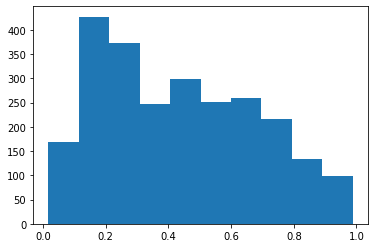

In [17]:
# plt.hist([len(g.split(' ')) for g in restaurant_X_train_negative['reviewContent']], range=(0,500))
# print([len(g.split(' ')) for g in restaurant_X_train_negative['reviewContent'][:10]])

print(classification_report(restaurant_y_predicted_test > 0.5, restaurant_y_test))


pos = restaurant_X_test[restaurant_X_test['flagged'] == 'Y']['reviewContent']
nag = restaurant_X_test[restaurant_X_test['flagged'] == 'N']['reviewContent']

# plt.hist([len(g.split(' ')) for g in pos], range=(0,100))

restaurant_X_train_positive_generated

plt.hist(restaurant_y_predicted_test)

# plt.hist([len(g.split(' ')) for g in restaurant_X_train_positive_generated['reviewContent']], range=(0,200))



In [31]:
for num_epochs in [5, 10, 15]:
    for sequence_length in [100, 200, 400]:
        print(f"Start training with num_epochs={num_epochs}, sequence_length={sequence_length}")
        build_model_3_restaurant(num_epochs=num_epochs, sequence_length=sequence_length)

Start training with num_epochs=5, sequence_length=100
There are 427 positive examples
There are 3821 generated positive examples
There are 2975 negative examples
Training samples: 2975 positive, 2975 negative
Model 3: Hotels reviews vocabulary size is 22731
Converted 16748 words (5983 misses)
training set shape: (5950, 100)
Model: "model_3_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, None, 300)         6819300   
                                                                 
 lstm_54 (LSTM)              (None, 128)               219648    
                                                                 
 dense_54 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,039,077
Trainable params: 219,777
Non-trainable params: 6,819,300
_________________________________________

186/186 [==============================] - 25s 122ms/step - loss: 0.5341 - accuracy: 0.7341
Epoch 2/10
186/186 [==============================] - 22s 116ms/step - loss: 0.4976 - accuracy: 0.7447
Epoch 3/10
186/186 [==============================] - 22s 118ms/step - loss: 0.4628 - accuracy: 0.7674
Epoch 4/10
186/186 [==============================] - 22s 120ms/step - loss: 0.4302 - accuracy: 0.7919
Epoch 5/10
186/186 [==============================] - 22s 121ms/step - loss: 0.4128 - accuracy: 0.7997
Epoch 6/10
186/186 [==============================] - 23s 124ms/step - loss: 0.3704 - accuracy: 0.8284
Epoch 7/10
186/186 [==============================] - 21s 115ms/step - loss: 0.3366 - accuracy: 0.8484
Epoch 8/10
186/186 [==============================] - 23s 122ms/step - loss: 0.3028 - accuracy: 0.8597
Epoch 9/10
186/186 [==============================] - 22s 117ms/step - loss: 0.2768 - accuracy: 0.8808
Epoch 10/10
186/186 [==============================] - 23s 121ms/step - loss: 0.2536

186/186 [==============================] - 25s 120ms/step - loss: 0.5382 - accuracy: 0.7363
Epoch 2/15
186/186 [==============================] - 21s 113ms/step - loss: 0.5027 - accuracy: 0.7439
Epoch 3/15
186/186 [==============================] - 23s 121ms/step - loss: 0.4705 - accuracy: 0.7573
Epoch 4/15
186/186 [==============================] - 21s 115ms/step - loss: 0.4340 - accuracy: 0.7871
Epoch 5/15
186/186 [==============================] - 22s 120ms/step - loss: 0.4117 - accuracy: 0.8039
Epoch 6/15
186/186 [==============================] - 22s 118ms/step - loss: 0.3676 - accuracy: 0.8311
Epoch 7/15
186/186 [==============================] - 23s 122ms/step - loss: 0.3488 - accuracy: 0.8385
Epoch 8/15
186/186 [==============================] - 23s 124ms/step - loss: 0.3136 - accuracy: 0.8575
Epoch 9/15
186/186 [==============================] - 22s 118ms/step - loss: 0.2921 - accuracy: 0.8719
Epoch 10/15
186/186 [==============================] - 23s 123ms/step - loss: 0.2515

Epoch 12/15
186/186 [==============================] - 100s 540ms/step - loss: 0.4840 - accuracy: 0.7553
Epoch 13/15
186/186 [==============================] - 104s 560ms/step - loss: 0.4871 - accuracy: 0.7457
Epoch 14/15
186/186 [==============================] - 99s 531ms/step - loss: 0.4694 - accuracy: 0.7600
Epoch 15/15
186/186 [==============================] - 98s 525ms/step - loss: 0.4590 - accuracy: 0.7741
              precision    recall  f1-score   support

       False       0.90      0.90      0.90       999
        True       0.27      0.27      0.27       135

    accuracy                           0.83      1134
   macro avg       0.58      0.58      0.58      1134
weighted avg       0.83      0.83      0.83      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.84      0.51      0.64       352
        True       0.21      0.56      0.30        80

    ac

# Model 4: Training with generated fake reviews on BERT

In [210]:
# Train BERT
import tensorflow_text as text 
def build_model_4_restaurant(num_epochs=1):
    
    # Add generated fake reviews into the training set
    restaurant_X_train_positive = restaurant_X_train[restaurant_X_train['flagged'] == 'Y']
    restaurant_X_train_negative = restaurant_X_train[restaurant_X_train['flagged'] == 'N']

    print(f'There are {len(restaurant_X_train_positive)} positive examples')
    print(f'There are {len(restaurant_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(restaurant_X_train_negative)} negative examples')

    restaurant_X_train_all_positive = pd.concat([restaurant_X_train_positive, restaurant_X_train_positive_generated], ignore_index=True)

    num_samples = min(len(restaurant_X_train_all_positive), len(restaurant_X_train_negative))
    restaurant_X_train_all_positive_sampled = restaurant_X_train_all_positive.sample(n=num_samples)
    restaurant_X_train_negative_sampled = restaurant_X_train_negative.sample(n=num_samples)

    restaurant_X_train_balanced = pd.concat([restaurant_X_train_all_positive_sampled, restaurant_X_train_negative_sampled], ignore_index=True).sample(frac=1)
    restaurant_y_train_balanced = restaurant_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(restaurant_X_train_balanced['flagged'] == 'Y')} positive, {sum(restaurant_X_train_balanced['flagged'] == 'N')} negative")

    # BERT has its own input and preprocessing
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1", trainable=True)
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = Dropout(0.2)(net)
    net = Dense(8, activation='relu')(net)
    net = Dense(1, activation='sigmoid')(net)
    model = tf.keras.Model(text_input, net)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    model.fit(restaurant_X_train_balanced['reviewContent'], restaurant_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    restaurant_y_predicted = model.predict(restaurant_X_dev['reviewContent'])
    print(classification_report(restaurant_y_predicted > 0.5, restaurant_y_dev))
    print('Dev set class distribution')
    print(restaurant_X_dev['flagged'].value_counts() / len(restaurant_X_dev))

    # Evaluate on the test set
    restaurant_y_predicted = model.predict(restaurant_X_test['reviewContent'])
    print(classification_report(restaurant_y_predicted > 0.5, restaurant_y_test))
    print('Test set class distribution')
    print(restaurant_X_test['flagged'].value_counts() / len(restaurant_X_test))


In [211]:
build_model_4_restaurant(num_epochs=5)

There are 420 positive examples
There are 2988 generated positive examples
There are 2982 negative examples
Training samples: 2982 positive, 2982 negative
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_mask': (Non  0           ['input_3[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'in

KeyboardInterrupt: 

In [209]:
for num_epochs in [5, 10, 15]:
    print(f"Start training with num_epochs={num_epochs}")
    build_model_4_restaurant(num_epochs=num_epochs)

Start training with num_epochs=5
There are 420 positive examples
There are 2988 generated positive examples
There are 2982 negative examples
Training samples: 2982 positive, 2982 negative
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
     

KeyboardInterrupt: 

# Model 5: Training with generated fake reviews on LSTM with Elmo embedding

In [22]:
def build_model_5_restaurant(num_epochs=2, sequence_length=50):
    # Add generated fake reviews into the training set
    restaurant_X_train_positive = restaurant_X_train[restaurant_X_train['flagged'] == 'Y']
    restaurant_X_train_negative = restaurant_X_train[restaurant_X_train['flagged'] == 'N']

    print(f'There are {len(restaurant_X_train_positive)} positive examples')
    print(f'There are {len(restaurant_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(restaurant_X_train_negative)} negative examples')

    restaurant_X_train_all_positive = pd.concat([restaurant_X_train_positive, restaurant_X_train_positive_generated], ignore_index=True)

    num_samples = min(len(restaurant_X_train_all_positive), len(restaurant_X_train_negative))
    restaurant_X_train_all_positive_sampled = restaurant_X_train_all_positive.sample(n=num_samples)
    restaurant_X_train_negative_sampled = restaurant_X_train_negative.sample(n=num_samples)

    restaurant_X_train_balanced = pd.concat([restaurant_X_train_all_positive_sampled, restaurant_X_train_negative_sampled], ignore_index=True).sample(frac=1)
    restaurant_y_train_balanced = restaurant_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(restaurant_X_train_balanced['flagged'] == 'Y')} positive, {sum(restaurant_X_train_balanced['flagged'] == 'N')} negative")

    m5_restaurant_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m5_restaurant_vectorizer.adapt(restaurant_X_train_balanced['reviewContent'].to_numpy())
    m5_restaurant_voc = m5_restaurant_vectorizer.get_vocabulary()
    print(f"Model 5: restaurants reviews vocabulary size is {len(m5_restaurant_voc)}")

    elmo_embeddings = get_elmo_embedding(m5_restaurant_voc)

    # Building the embedding layer using Elmo results
    elmo_embedding_dim = 1024
    num_words = len(m5_restaurant_voc)

    m5_restaurant_embedding_matrix = np.zeros((num_words, elmo_embedding_dim))
    for i, word in enumerate(m5_restaurant_voc):
        m5_restaurant_embedding_matrix[i] = elmo_embeddings[i][0]

    m5_restaurant_embedding_layer = Embedding(
        num_words,
        elmo_embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(m5_restaurant_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    restaurant_X_train_ready = m5_restaurant_vectorizer(restaurant_X_train_balanced['reviewContent']).numpy()
    restaurant_X_dev_ready = m5_restaurant_vectorizer(restaurant_X_dev['reviewContent']).numpy()
    restaurant_X_test_ready = m5_restaurant_vectorizer(restaurant_X_test['reviewContent']).numpy()
    print(f'training set shape: {restaurant_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_5_restaurant')
    model.add(m5_restaurant_embedding_layer)
    model.add(LSTM(16, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(restaurant_X_train_ready, restaurant_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    restaurant_y_predicted = model.predict(restaurant_X_dev_ready)
    print(classification_report(restaurant_y_predicted > 0.5, restaurant_y_dev))
    print('Dev set class distribution')
    print(restaurant_X_dev['flagged'].value_counts() / len(restaurant_X_dev))

    # Evaluate on the test set
    restaurant_y_predicted = model.predict(restaurant_X_test_ready)
    print(classification_report(restaurant_y_predicted > 0.5, restaurant_y_test))
    print('Test set class distribution')
    print(restaurant_X_test['flagged'].value_counts() / len(restaurant_X_test))


In [ ]:
build_model_5_restaurant(num_epochs=10, sequence_length=100)

There are 5191 positive examples
There are 8220 generated positive examples
There are 36895 negative examples
Training samples: 13411 positive, 13411 negative
Model 5: restaurants reviews vocabulary size is 56549


In [35]:
for num_epochs in [5, 10, 15]:
    for sequence_length in [100, 200, 400]:
        print(f"Start training with num_epochs={num_epochs}, sequence_length={sequence_length}")
        build_model_5_restaurant(num_epochs=num_epochs, sequence_length=sequence_length)

Start training with num_epochs=5, sequence_length=100
There are 427 positive examples
There are 3821 generated positive examples
There are 2975 negative examples
Training samples: 2975 positive, 2975 negative
Model 5: Hotels reviews vocabulary size is 22548
training set shape: (5950, 100)
Model: "model_5_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_64 (Embedding)    (None, None, 1024)        23089152  
                                                                 
 lstm_64 (LSTM)              (None, 128)               590336    
                                                                 
 dense_70 (Dense)            (None, 1)                 129       
                                                                 
Total params: 23,679,617
Trainable params: 590,465
Non-trainable params: 23,089,152
_________________________________________________________________
None
Epoc

186/186 [==============================] - 52s 268ms/step - loss: 0.5426 - accuracy: 0.7334
Epoch 2/10
186/186 [==============================] - 50s 269ms/step - loss: 0.5028 - accuracy: 0.7351
Epoch 3/10
186/186 [==============================] - 50s 269ms/step - loss: 0.4909 - accuracy: 0.7353
Epoch 4/10
186/186 [==============================] - 50s 269ms/step - loss: 0.4575 - accuracy: 0.7645
Epoch 5/10
186/186 [==============================] - 51s 273ms/step - loss: 0.4157 - accuracy: 0.7941
Epoch 6/10
186/186 [==============================] - 49s 264ms/step - loss: 0.3672 - accuracy: 0.8277
Epoch 7/10
186/186 [==============================] - 49s 264ms/step - loss: 0.3318 - accuracy: 0.8551
Epoch 8/10
186/186 [==============================] - 47s 253ms/step - loss: 0.2879 - accuracy: 0.8746
Epoch 9/10
186/186 [==============================] - 47s 255ms/step - loss: 0.2540 - accuracy: 0.8933
Epoch 10/10
186/186 [==============================] - 47s 254ms/step - loss: 0.2088

186/186 [==============================] - 51s 260ms/step - loss: 0.5498 - accuracy: 0.7281
Epoch 2/15
186/186 [==============================] - 49s 262ms/step - loss: 0.5090 - accuracy: 0.7398
Epoch 3/15
186/186 [==============================] - 48s 259ms/step - loss: 0.4927 - accuracy: 0.7430
Epoch 4/15
186/186 [==============================] - 48s 259ms/step - loss: 0.4671 - accuracy: 0.7661
Epoch 5/15
186/186 [==============================] - 48s 257ms/step - loss: 0.4175 - accuracy: 0.8010
Epoch 6/15
186/186 [==============================] - 48s 257ms/step - loss: 0.3742 - accuracy: 0.8217
Epoch 7/15
186/186 [==============================] - 48s 258ms/step - loss: 0.3348 - accuracy: 0.8476
Epoch 8/15
186/186 [==============================] - 48s 258ms/step - loss: 0.3077 - accuracy: 0.8573
Epoch 9/15
186/186 [==============================] - 50s 267ms/step - loss: 0.2650 - accuracy: 0.8855
Epoch 10/15
186/186 [==============================] - 50s 271ms/step - loss: 0.2370

KeyboardInterrupt: 

# 